# <div align="center"> Experiments </div>

______________

The notebook is organized as followed:

- **Part 1 :** Run an experiment: detailed tutorial to run an experiment

- **Part 2 :** Evaluating the method for regression tasks

- **Part 3 :** Evaluating the method for classification tasks

- **Part 4 :** Additional experiments
______________

In [1]:
from utils import *
from net_bml import Net
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import pylab

# Part 1: Run an experiment (tutorial)

## 1. Choose a dataset

Choose the data between the following dataset:

Regression problems:

- `bostonHousing`
- `energy`
- `naval-propulsion-plant`
- `power-plant`
- `wine-quality-red`

Classification problems:

- `MNIST`

Then select the batch sizes (`batch_size_train`, `batch_size_test`) used for the next training

In [168]:
data_name = "bostonHousing"
batch_size_train= 32
batch_size_test= 32

training_set, testing_set, train_loader, test_loader, x_mean, x_std, y_mean, y_std = load_data(data_name=data_name,
                                                                                                          batch_size_train=batch_size_train, 
                                                                                                          batch_size_test = batch_size_test,
                                                                                                          normalize=True)

print("The shape of the training set is:")
print(training_set.data.size())
print("The shape of the testing set is:")
print(testing_set.data.size())

The shape of the training set is:
torch.Size([455, 13])
The shape of the testing set is:
torch.Size([51, 13])


## 2. Create the network

First let's choose a network architecture. We only study here linear layers (ReLu activation) separated by a dropout layer. The weights $W_{i}$ and bias $b_{i}$ of the linear layers are regularized ($L_2$) with the regularization parameter $\lambda$.

You have to set the following parameters:
- the number of input data $N$ (eg.`N=1000`)
- the number of input features $n_{in}$ (eg. `n_in=784`)
- the number of classes $n_{out}$ (eg. `n_out=10`)
- number of layers and neurons (eg. `layer_sizes=[256,256,256]`)
- the dropout rate $p$ (eg. `dropout_rate=0.5`)
- $\tau$ (eg. `tau=0.5`)

Please note the regularization parameter $\lambda$ is compute according to the following formula:


<div align="center"> $\lambda=\frac{pl^{2}}{2N\tau}$ </div>
    
where $l$ is the prior-length scale. It is arbitrary set of `1e-2`

In [169]:
# Set the parameters
N=training_set.data.size()[0]
n_in=training_set.data.size()[1]
n_out=1
layer_sizes=[5000,1000]
dropout_rate= 0.005 
tau=0.1
l=1e-2
lbda = l**2 * (1 - dropout_rate) / (2. * N * tau)

# Create the network
network = Net(N=N,
              n_in=n_in,
              n_out=n_out,
              layer_sizes=layer_sizes,
              dropout_rate=dropout_rate,
              tau=tau)#.float()

print(network)

Net(
  (model): Sequential(
    (Dropout0): Dropout(p=0.005, inplace=False)
    (Linear0): Linear(in_features=13, out_features=5000, bias=True)
    (Relu): ReLU()
    (Dropout1): Dropout(p=0.005, inplace=False)
    (Linear1): Linear(in_features=5000, out_features=1000, bias=True)
    (Dropout2): Dropout(p=0.005, inplace=False)
    (Linear2): Linear(in_features=1000, out_features=1, bias=True)
  )
)


## 3. Train the model

Here are the useful functions to run the training.

You have to choose the type of the problem, either classification or regression:
- `problem="classification"` or `problem=regression`

It will define the loss to use, either NLL for classification or RMSE for regression.

Then, you have to choose the parameters of the training:
- number of epochs (eg. `n_epochs=10`)
- learning rate (eg. `learning_rate=0.01`)
- momentum (eg. `momentum=0.5`)

In [170]:
# Type of the problem
problem="regression"

# Training parameters
n_epochs = 1
learning_rate = 1e-6
momentum = 0.5

optimizer = optim.Adam(network.parameters(), 
                      lr=learning_rate,
                     weight_decay=lbda)

In [171]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(network,epoch,aff=False):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        optimizer.zero_grad()
        

        if data_name=="MNIST":
            data=data.squeeze(dim=1)
            data=data.flatten(1,2)
            
        output = network(data)
        
        if problem=="classification":
            loss = F.nll_loss(output, target)
        if problem=="regression":
            output=output.squeeze(1)
            loss = F.mse_loss(output,target,reduction="mean")
            #print(loss)
            
            
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            if aff:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def test(network,aff=False):
    #network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            
            if data_name=="MNIST":
                data=data.squeeze(dim=1)
                data=data.flatten(1,2)
                
            output = network(data)
            
            if problem=="classification":
                test_loss += F.nll_loss(output, target, size_average=False).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
            if problem=="regression":
                output=output.squeeze(1)
                test_loss += F.mse_loss(output,target,reduction="mean").item()
                
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    if aff:
        if problem=="classification":
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))
        if problem=="regression":
            print('\nTest set: Avg. loss: {:.4f}\n'.format(test_loss))


Then let's run the training:

In [172]:
n_epochs=10
for epoch in range(1, n_epochs + 1):
    train(network,epoch,aff=True)
    test(network,aff=True)

Train Epoch: 1 [0/455 (0%)]	Loss: 0.836902
Train Epoch: 1 [320/455 (67%)]	Loss: 0.734232

Test set: Avg. loss: 0.0264

Train Epoch: 2 [0/455 (0%)]	Loss: 0.693336
Train Epoch: 2 [320/455 (67%)]	Loss: 0.540062

Test set: Avg. loss: 0.0205

Train Epoch: 3 [0/455 (0%)]	Loss: 0.590523
Train Epoch: 3 [320/455 (67%)]	Loss: 0.398566

Test set: Avg. loss: 0.0162

Train Epoch: 4 [0/455 (0%)]	Loss: 0.518835
Train Epoch: 4 [320/455 (67%)]	Loss: 0.318779

Test set: Avg. loss: 0.0128

Train Epoch: 5 [0/455 (0%)]	Loss: 0.457957
Train Epoch: 5 [320/455 (67%)]	Loss: 0.276379

Test set: Avg. loss: 0.0105

Train Epoch: 6 [0/455 (0%)]	Loss: 0.431974
Train Epoch: 6 [320/455 (67%)]	Loss: 0.237845

Test set: Avg. loss: 0.0092

Train Epoch: 7 [0/455 (0%)]	Loss: 0.406743
Train Epoch: 7 [320/455 (67%)]	Loss: 0.212028

Test set: Avg. loss: 0.0081

Train Epoch: 8 [0/455 (0%)]	Loss: 0.379751
Train Epoch: 8 [320/455 (67%)]	Loss: 0.202675

Test set: Avg. loss: 0.0071

Train Epoch: 9 [0/455 (0%)]	Loss: 0.350066
Train

In [11]:
for i in range(10):
    print(network(training_set.data[i]))
    print(training_set.targets[i])

tensor([-0.4273], grad_fn=<AddBackward0>)
tensor(-0.6478)
tensor([0.4599], grad_fn=<AddBackward0>)
tensor(0.1172)
tensor([-0.2662], grad_fn=<AddBackward0>)
tensor(-0.6075)
tensor([-0.6563], grad_fn=<AddBackward0>)
tensor(-0.6894)
tensor([0.0563], grad_fn=<AddBackward0>)
tensor(-0.4490)
tensor([0.4744], grad_fn=<AddBackward0>)
tensor(0.2474)
tensor([-0.6937], grad_fn=<AddBackward0>)
tensor(-0.6782)
tensor([-0.3629], grad_fn=<AddBackward0>)
tensor(-0.6452)
tensor([0.1290], grad_fn=<AddBackward0>)
tensor(-0.3584)
tensor([-0.4806], grad_fn=<AddBackward0>)
tensor(-0.6505)


## 4. Perform the prediction

In [31]:
def prediction(network,testing_set,normalize=True):

    #network.eval()
    with torch.no_grad():
        if normalize:
            standard_pred = y_std*network(testing_set.data).squeeze(dim=1)+y_mean
        else:
            standard_pred = network(testing_set.data)

    rmse_standard_pred = np.mean((y_std*testing_set.targets.numpy()+y_mean - standard_pred.numpy())**2.)**0.5
    
    T = 10

    Yt_hat=[]
    for _ in range(T):
        Yt_hat.append(network(testing_set.data).squeeze(dim=1).data.numpy())
        #optimizer.step()
    Yt_hat=np.array(Yt_hat)
    if normalize:
        Yt_hat = Yt_hat * y_std + y_mean
    MC_pred = np.mean(Yt_hat, 0)
    rmse = np.mean((testing_set.targets.numpy()*y_std + y_mean - MC_pred)**2.)**0.5

    # We compute the test log-likelihood
    ll = (logsumexp(-0.5 * tau * (testing_set.targets.numpy()* y_std + y_mean - Yt_hat)**2., 0) - np.log(T)
        - 0.5*np.log(2*np.pi) + 0.5*np.log(tau))
    test_ll = np.mean(ll)

    # We are done!
    print("RMSE Standard pred")
    print(rmse_standard_pred)
    print("RMSE MC pred")
    print(rmse)
    print("LL")
    print(test_ll)
    
    return rmse_standard_pred, rmse, test_ll

prediction(network,testing_set,normalize=True)

RMSE Standard pred
9.984323802930161
RMSE MC pred
9.92241593936328
LL
-6.8250685


(9.984323802930161, 9.92241593936328, -6.8250685)

# Part 2 - Evaluating the method for regression tasks

To evaluate the dropout, we compute RMSE and predictive log-likelihood on 5 different dataset. This is a replication of the experiment made in Hernandez-Lobato, J M and Adams, R P. Probabilistic ´backpropagation for scalable learning of bayesian neural networks. In ICML-15, 2015.

The idea is to compare the uncertainty quality obtained from aof dropout to that of specialised methods developed to capture uncertainty on very basic examples. To do so, we used multi-layer perceptrons with two layers and 5 simple datasets built for regression: `bostonHousing`, `energy`, `naval-propulsion-plant`, `power-plant`, `wine-quality-red`. Then, we perform a grid search on $\tau$ and the dropout_rate in order to find the best set of parameters. In the end, we keep the best values of RMSE and LL found.

**Technical remark:** before running the following cell, we ran the training for each dataset in order to find reasonable values of learning rate and number of epochs to get the convergence.

In [32]:
n_epochss=[80, 20,2,4,10]
l_rates=[1e-6,1e-5,1e-2,1e-2,1e-5]

for j,data_name in enumerate(["bostonHousing","energy","naval-propulsion-plant",
                              "power-plant","wine-quality-red"]):
    
    print("Dataset : {} \n".format(data_name))
    print("Number of epochs={} / l_rate={}".format(n_epochss[j],l_rates[j]))
    
    batch_size_train= 32
    batch_size_test= 32

    training_set, testing_set, train_loader, test_loader, x_mean, x_std, y_mean, y_std = load_data(data_name=data_name,
                                                                                                              batch_size_train=batch_size_train, 
                                                                                                              batch_size_test = batch_size_test,
                                                                                                              normalize=True)

    for dropout_rate in [0.005, 0.01, 0.1]:
        for tau in [0.1, 0.2]:
            print("tau = {} ; dropout_rate = {}".format(dropout_rate,tau))
            # Set the parameters
            N=training_set.data.size()[0]
            n_in=training_set.data.size()[1]
            n_out=1
            layer_sizes=[5000,100]
            l=1e-2
            lbda = (dropout_rate*l**2)/(2*N*tau)

            # Create the network
            network = Net(N=N,
                          n_in=n_in,
                          n_out=n_out,
                          layer_sizes=layer_sizes,
                          dropout_rate=dropout_rate,
                          tau=tau)

            # Type of the problem
            problem="regression"

            # Training parameters
            n_epochs = n_epochss[j]
            learning_rate = l_rates[j]
            momentum = 0.5

            optimizer = optim.Adam(network.parameters(), 
                                  lr=learning_rate,
                                 weight_decay=lbda)

            train_losses = []
            train_counter = []
            test_losses = []
            test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

            print("Training")
            for epoch in range(1, n_epochs + 1):
                train(network,epoch)
                test(network)

            prediction(network, testing_set)
            print("\n")

Dataset : bostonHousing 

Number of epochs=80 / l_rate=1e-06
tau = 0.005 ; dropout_rate = 0.1
Training
RMSE Standard pred
3.177891479435054
RMSE MC pred
3.157618462038541
LL
-2.5690389


tau = 0.005 ; dropout_rate = 0.2
Training
RMSE Standard pred
3.118499862027467
RMSE MC pred
3.1328478119113377
LL
-2.6907983


tau = 0.01 ; dropout_rate = 0.1
Training
RMSE Standard pred
3.035180915329717
RMSE MC pred
3.02069835142032
LL
-2.5231209


tau = 0.01 ; dropout_rate = 0.2
Training
RMSE Standard pred
3.142850324697654
RMSE MC pred
3.1632698479067938
LL
-2.728122


tau = 0.1 ; dropout_rate = 0.1
Training
RMSE Standard pred
4.19420872096799
RMSE MC pred
2.8526746279516324
LL
-2.4934983


tau = 0.1 ; dropout_rate = 0.2
Training
RMSE Standard pred
3.7200559999496283
RMSE MC pred
3.0610693879312003
LL
-2.536773


Dataset : energy 

Number of epochs=20 / l_rate=1e-05
tau = 0.005 ; dropout_rate = 0.1
Training
RMSE Standard pred
2.624294549517907
RMSE MC pred
2.6233059094105178
LL
-2.4184387


tau = 0

Here is a summary of the values of RMSE and LL we get with the dropout method. We compare it to the values obtained in the paper and those of other methods. The first value indicated is the RMSE (we want it to be the smallest), the second the LL (we want it to be the highest) :

| Dataset        | Dropout (our implementation) | Dropout (paper result)  | VI             | PB             |
| -------------  |:----------------------------:| :----------------------:| :-------------:| :-------------:|
| BostonHousing  | 2.85 / -2.49                 |  2.97 /-2.46            |  4.32 / -2.90  |3.01 / -2.57    |
| energy         | 2.56 / -2.39                 |  1.66 / -1.99           |  2.65 / -2.39  |  1.80 / -2.39  |
| naval          | 0.01 / -1.72                 |  0.01 / 3.80            |  0.01 / 3.73   |  0.01 /3.73    |
| power-plant    | 4.4 / -3.63                  |  4.02 / -2.80           |  4.33 / -2.89  |   4.12 / -2.84 |
| wine-quality-rd| 0.63 / -1.76                 |  0.62 / -0.93           |  0.65 / -0.98  | 0.64 / -0.97   |

__Comments :__

- As we can see, we find results in the magnitude. The results of the paper seems reproductibe. Nevertheless, in some cases the results we find are not as good as those presented in the paper. It may be due to the fact that we can get a better convergence. Moreover, at it is suggested by the author, due to the small sizes of the datasets splitting the data differently could lead to different results. It may explain why our results are slightly different.

- Here we merely wanted to see whether the results were reproductible for an home-made implementation. Therefore, we ran the experiment for one splitting, that is why our results are not provided with error intervals.

# Part 3 - Evaluation for a classification task

Now let's assess the model classification confidence with the MNIST dataset. Once again, we train a multi-layer perceptron (MNIST data are flatten) with dropout between each layer. We used the settings of the paper and therefore chose a dropout probability of 0.5.

In [13]:
data_name = "MNIST"
batch_size_train= 128
batch_size_test= 2000

training_set, testing_set, train_loader, test_loader, _, _, _, _ = load_data(data_name=data_name,
                                                                              batch_size_train=batch_size_train, 
                                                                              batch_size_test = batch_size_test,
                                                                              normalize=False)

# Set the parameters
N=training_set.data.size()[0]
n_in=training_set.data.size()[1]
n_out=10
layer_sizes=[256,256]
dropout_rate= 0.5 
tau=0.1
l=1e-2
lbda = l**2 * (1 - dropout_rate) / (2. * N * tau)

# Create the network
network = Net(N=N,
              n_in=n_in,
              n_out=n_out,
              layer_sizes=layer_sizes,
              dropout_rate=dropout_rate,
              tau=tau).float()

# Type of the problem
problem="classification"

# Training parameters
n_epochs = 4
learning_rate = 1e-3
momentum = 0.5

optimizer = optim.Adam(network.parameters(), 
                      lr=learning_rate,
                      weight_decay=lbda)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

for epoch in range(1, n_epochs + 1):
    train(network,epoch,aff=True)
    test(network,aff=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316645
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.619254
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.011961
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.836688
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.588995
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.664449
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.808232
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.632259
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.629676
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.447476
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.558832
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.513071
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.496068
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.401862
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.433291
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.345285
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.563680
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.479602
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.462000
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.554463
Train Epoch: 1 [

Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.303733
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.380111
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.231685
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.317326
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.267623
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.232556
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.192909
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.256267
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.263079
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.194494
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.439286
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.344878
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.179493
Train Epoch: 4 [43520/60000 (72%)]	Loss: 0.345514
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.225892
Train Epoch: 4 [46080/60000 (77%)]	Loss: 0.142262
Train Epoch: 4 [47360/60000 (79%)]	Loss: 0.224535
Train Epoch: 4 [48640/60000 (81%)]	Loss: 0.108145
Train Epoch: 4 [49920/60000 (83%)]	Loss: 0.220127
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.143475


Once the model is trained (for the experiment an accuracy of 92% is enough), we set of testing data for which the results of the predictor are correct and incorrect in order to see how the variance evolves and therefore to see if we can quantify the confidence of the classifier. To do so, each data chosen is fed to the classifier $T=100$ times. We collect the result of the $T$ forward passes and plot the probability distribution generated by the classifiers:

In [89]:
# Find the indices of data labelled 7
indices_7=[]

for i in range(testing_set.targets.numpy().shape[0]):
    if int(testing_set.targets[i].numpy())==7:
        indices_7.append(i)


# We keep 3 data for which the networks predicted 7, 3 and 9
# (3 and 9 because they are the most common mistakes)

data_kept=[]
preds=[]
cpt_7=0
cpt_3=0
cpt_9=0
        
for i in indices_7:
    if cpt_9<3 or cpt_7<3 or cpt_3<3:
        res=[0]*10
        for _ in range(100):
            pred=int(network(testing_set.data[i].float()).argmax().numpy())
            res[pred]+=1

        pred=np.argmax(res)

        if pred==7 and cpt_7<3:
            data_kept.append(i)
            preds.append(pred)
            cpt_7+=1
        if pred==3 and cpt_3<3:
            data_kept.append(i)
            preds.append(pred)
            cpt_3+=1
        if pred==9 and cpt_9<3:
            data_kept.append(i)
            preds.append(pred)
            cpt_9+=1

print(data_kept)

[0, 17, 26, 684, 689, 771, 846, 1500, 3808]


The data chosen are:

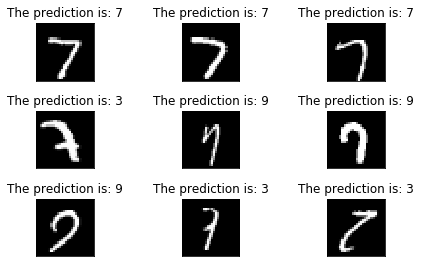

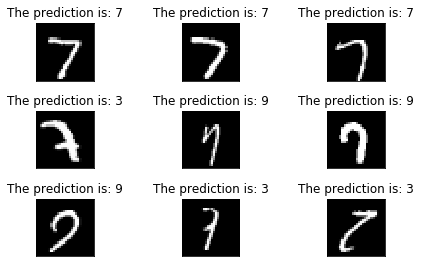

In [90]:
fig = plt.figure()
for j,ind in enumerate(data_kept):
    plt.subplot(3,3,j+1)
    plt.tight_layout()
    plt.imshow(testing_set.data[ind].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("The prediction is: {}".format(preds[j]))
    plt.xticks([])
    plt.yticks([])
fig

Now let's store and plot the probabilities output by the network:

In [91]:
T=100
probs=np.zeros((1,100,10))

for j,ind in enumerate(data_kept):
    
    int_probs=[]

    for _ in range(T):
        out=network(testing_set.data[ind].float()).data.numpy()
        int_probs.append(out)
    
    int_probs=np.array(int_probs)
    probs=np.concatenate((probs,np.expand_dims(int_probs,axis=0)),axis=0)

probs=probs[1:]
print(probs.shape)

(9, 100, 10)


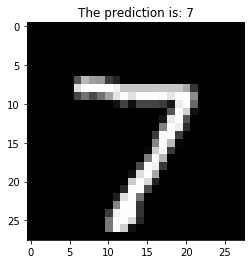

Mean of 7 is -0.44568359375
Std of 7 is 4.434495767057806
Mean of 3 is -720.1932424926758
Std of 3 is 318.4453827162472
Mean of 9 is -1105.6463952636718
Std of 9 is 354.6795480259494


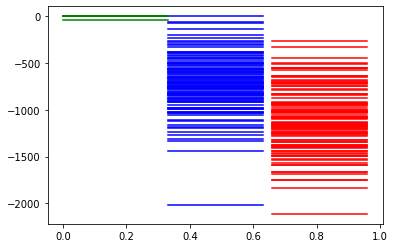

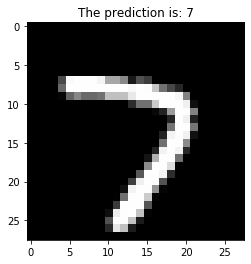

Mean of 7 is -4.2052734386920925
Std of 7 is 25.512851684274246
Mean of 3 is -695.2705865478515
Std of 3 is 361.10889875760984
Mean of 9 is -1208.604503173828
Std of 9 is 445.09137497943135


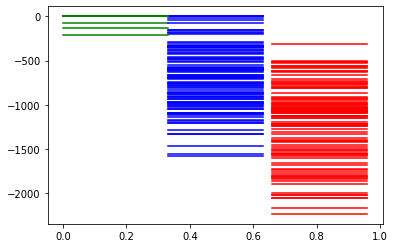

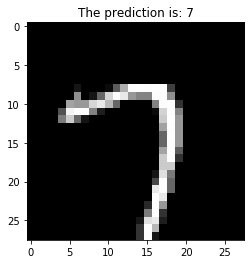

Mean of 7 is -2.809793553351119
Std of 7 is 19.355549659606535
Mean of 3 is -712.5278707885742
Std of 3 is 306.2730442504503
Mean of 9 is -541.7845683300495
Std of 9 is 308.52398043559987


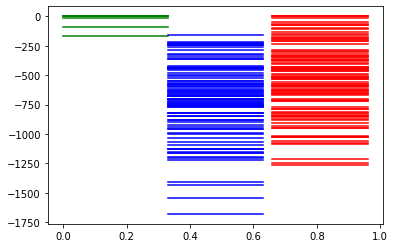

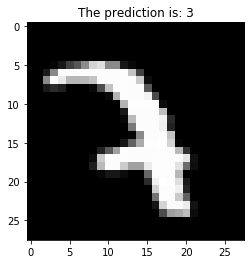

Mean of 7 is -166.3182216419232
Std of 7 is 169.32380066920646
Mean of 3 is -91.07987977687156
Std of 3 is 145.74482289908983
Mean of 9 is -581.2104155158996
Std of 9 is 342.2042900103587


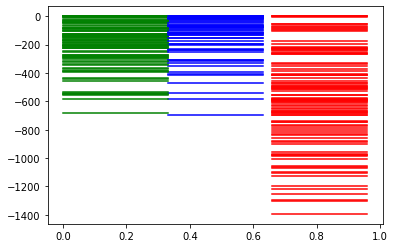

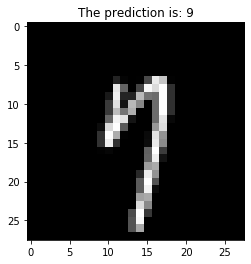

Mean of 7 is -72.09919009065976
Std of 7 is 91.52230491865006
Mean of 3 is -356.105879573822
Std of 3 is 184.11326485868787
Mean of 9 is -45.420031105279925
Std of 9 is 67.46896851745672


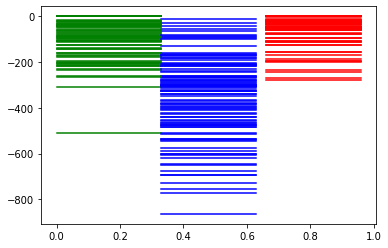

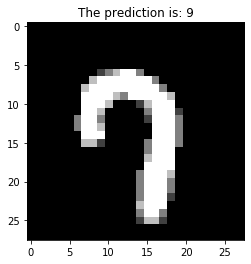

Mean of 7 is -100.91898806405952
Std of 7 is 172.5474467640916
Mean of 3 is -881.5026739501953
Std of 3 is 367.1096967344374
Mean of 9 is -153.66445498466493
Std of 9 is 203.06371488324126


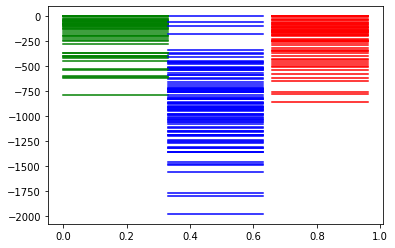

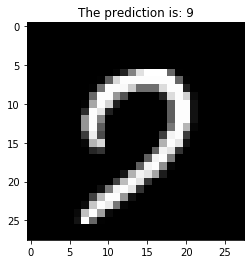

Mean of 7 is -176.15139235257936
Std of 7 is 178.0022079465066
Mean of 3 is -586.4142552900312
Std of 3 is 247.58753344588428
Mean of 9 is -93.94848027966891
Std of 9 is 153.39824855186825


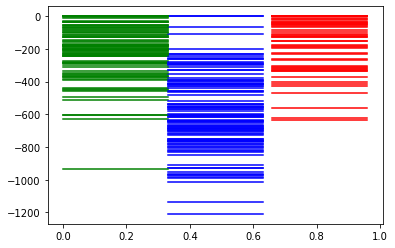

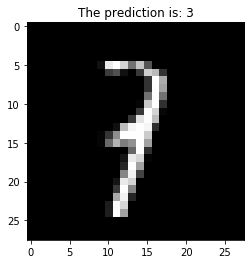

Mean of 7 is -388.35697986110273
Std of 7 is 261.9527187143238
Mean of 3 is -100.0556357061863
Std of 3 is 159.0874609993368
Mean of 9 is -627.7053552246093
Std of 9 is 274.31337576627834


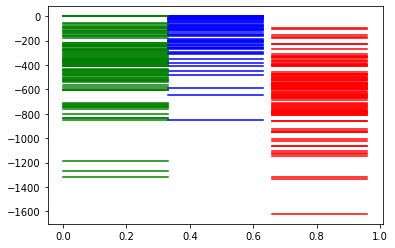

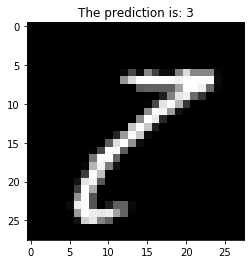

Mean of 7 is -675.1861260986328
Std of 7 is 368.2408146207551
Mean of 3 is -56.570047228336335
Std of 3 is 120.62636009461663
Mean of 9 is -880.9181520080566
Std of 9 is 332.14631822603434


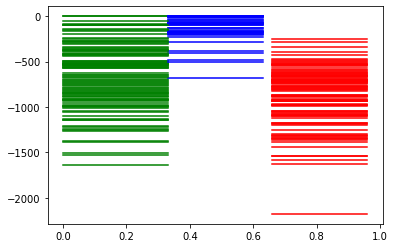

In [155]:
for i in range(9):
    
    plt.imshow(testing_set.data[data_kept[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("The prediction is: {}".format(preds[i]))
    plt.show()
    
    print("Mean of 7 is {}".format(np.mean(probs[i,:,7])))
    print("Std of 7 is {}".format(np.std(probs[i,:,7])))
    print("Mean of 3 is {}".format(np.mean(probs[i,:,3])))
    print("Std of 3 is {}".format(np.std(probs[i,:,3])))
    print("Mean of 9 is {}".format(np.mean(probs[i,:,9])))
    print("Std of 9 is {}".format(np.std(probs[i,:,9])))
    
    plt.figure()
    for j in range(probs[i].shape[0]):
        plt.plot([0,0.33],[probs[i,j,7],probs[i,j,7]],c="green")
        plt.plot([0.33,0.63],[probs[i,j,3],probs[i,j,3]],c="blue")
        plt.plot([0.66,0.96],[probs[i,j,9],probs[i,j,9]],c="red")

    plt.show()

In summary, we can store the results in the following figure:

![title](figures/fig_BML.png)

**Comments:**

- for this classification study, we choose three cases: the number 7 is predicted 7 (correct prediction), the number 7 is predicted 3 (false prediction), the number 7 is predicted 9 (false prediction) (remark: we chose cases for which the correct or wrong prediction appears with a frequency higher than 50%). For all those cases, we fed the classifier with the input image 100 times and store the probabilities output by the network. Then we plotted the probabilities of 3 classes (3,7,9) because they correspond to the mostly predicted classes. In this study, we want to see whether doing several forward pass (with dropout updates) give us information about the confidence of the prediction.

- As we can see, when the prediction is correct (3 first cases), the score obtained by the class 7 (green lines) is always very high and the variance of the values obtained is small (mentionned under the data image). On the contrary, when the networks is predicting the wrong class (6 other cases), we see that the standard deviation of the predicted class is very high and therefore we cannot be confident with the result. Moreover, we see that the "confidence interval" of this class overlap the "confidence intervals" of the other classes.

- In conclusion, for a classification task, we see that using the dropout Network allows us to get some information about the confidence of the network. For a wrong prediction, even though the score output is high, by doing several forward passes, we see that we can estimate a kind of confidence interval.

# Part 4: Additional experiments 

## About the running time

In [167]:
from time import time

network.train()
with torch.no_grad():
    deb=time()
    network(testing_set.data.float())
    print("It took {}s to the Dropout network to predict".format(time()-deb))

It took 0.2845420837402344s to the Dropout network to predict


In [166]:
deb=time()
network.eval()
network(testing_set.data.float())
print("It took {}s to the network without Dropout to predict".format(time()-deb))

It took 0.17604303359985352s to the network without Dropout to predict
